# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="E:/ML/Reinforcement/deep-reinforcement-learning/p1_navigation/Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
#env_info = env.reset(train_mode=False)[brain_name] # reset the environment
#state = env_info.vector_observations[0]            # get the current state
#score = 0                                          # initialize the score
#while True:
#    action = np.random.randint(action_size)        # select an action
#    env_info = env.step(action)[brain_name]        # send the action to the environment
#    next_state = env_info.vector_observations[0]   # get the next state
#    reward = env_info.rewards[0]                   # get the reward
#    done = env_info.local_done[0]                  # see if episode has finished
#    score += reward                                # update the score
#    state = next_state                             # roll over the state to next time step
#    if done:                                       # exit loop if episode finished
#        break
    
#print("Score: {}".format(score))

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
import numpy as np
import random
from collections import namedtuple, deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [6]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 3e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 10        # how often to update the network

In [8]:
# create an agent class
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Agent():
    def __init__(self, state_size, action_size, seed):

        self.state_size = state_size,
        self.action_size = action_size
        
        self.Qnet_local = QNetwork(state_size, action_size, seed).to(device)
        self.Qnet_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.Qnet_local.parameters(), lr=LR)

        self.seed = random.seed(seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
        
    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.Qnet_local.eval()
        with torch.no_grad():
            action_values = self.Qnet_local(state)
        self.Qnet_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.Qnet_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.Qnet_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.Qnet_local, self.Qnet_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
            
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)    

In [19]:
state

array([0.        , 0.        , 1.        , 0.        , 0.45669347,
       1.        , 0.        , 0.        , 0.        , 0.24367732,
       0.        , 1.        , 0.        , 0.        , 0.17223598,
       0.        , 0.        , 1.        , 0.        , 0.78546137,
       0.        , 1.        , 0.        , 0.        , 0.22639143,
       1.        , 0.        , 0.        , 0.        , 0.39459786,
       0.        , 1.        , 0.        , 0.        , 0.45442775,
       0.        , 0.        ])

In [9]:
agent = Agent(state_size=env_info.vector_observations[0].shape[0], 
              action_size=brain.vector_action_space_size, seed=33)

In [10]:
n_episodes=3000
max_t = 50000
eps_start=1.0 
eps_end=0.01 
eps_decay=0.99

In [11]:
scores = []                        # list containing scores from each episode
scores_window = deque(maxlen=100)  # last 100 scores
eps = eps_start                    # initialize epsilon
for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0] 
    score = 0
    for t in range(max_t):
        action = agent.act(state, eps)
        result = env.step(int(action))[brain_name] 
        next_state = result.vector_observations[0]   # get the next state
        reward = result.rewards[0]                   # get the reward
        done = result.local_done[0]                  # see if episode has finished
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
            
    scores_window.append(score)       # save most recent score
    scores.append(score)              # save most recent score
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    if i_episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    if np.mean(scores_window)>=13.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
        torch.save(agent.Qnet_local.state_dict(), 'checkpoint.pth')
        break


1
Episode 1	Average Score: 0.002
Episode 2	Average Score: 0.003
Episode 3	Average Score: 0.334
Episode 4	Average Score: 0.255
Episode 5	Average Score: 0.606
Episode 6	Average Score: 0.177
Episode 7	Average Score: 0.148
Episode 8	Average Score: 0.129
Episode 9	Average Score: 0.0010
Episode 10	Average Score: 0.1011
Episode 11	Average Score: 0.0912
Episode 12	Average Score: 0.0013
Episode 13	Average Score: 0.0814
Episode 14	Average Score: 0.0715
Episode 15	Average Score: 0.1316
Episode 16	Average Score: 0.1917
Episode 17	Average Score: 0.1218
Episode 18	Average Score: 0.2219
Episode 19	Average Score: 0.2120
Episode 20	Average Score: 0.3021
Episode 21	Average Score: 0.2922
Episode 22	Average Score: 0.3223
Episode 23	Average Score: 0.3524
Episode 24	Average Score: 0.2925
Episode 25	Average Score: 0.2426
Episode 26	Average Score: 0.3127
Episode 27	Average Score: 0.3028
Episode 28	Average Score: 0.2929
Episode 29	Average Score: 0.3830
Episode 30	Average Score: 0.4331
Episode 31	Average Score:

In [2]:
string = "Episode 1	Average Score: 0.002 Episode 2	Average Score: 0.003 Episode 3	Average Score: 0.334 Episode 4	Average Score: 0.255 Episode 5	Average Score: 0.606 Episode 6	Average Score: 0.177 Episode 7	Average Score: 0.148 Episode 8	Average Score: 0.129 Episode 9	Average Score: 0.0010 Episode 10	Average Score: 0.1011 Episode 11	Average Score: 0.0912 Episode 12	Average Score: 0.0013 Episode 13	Average Score: 0.0814 Episode 14	Average Score: 0.0715 Episode 15	Average Score: 0.1316 Episode 16	Average Score: 0.1917 Episode 17	Average Score: 0.1218 Episode 18	Average Score: 0.2219 Episode 19	Average Score: 0.2120 Episode 20	Average Score: 0.3021 Episode 21	Average Score: 0.2922 Episode 22	Average Score: 0.3223 Episode 23	Average Score: 0.3524 Episode 24	Average Score: 0.2925 Episode 25	Average Score: 0.2426 Episode 26	Average Score: 0.3127 Episode 27	Average Score: 0.3028 Episode 28	Average Score: 0.2929 Episode 29	Average Score: 0.3830 Episode 30	Average Score: 0.4331 Episode 31	Average Score: 0.3932 Episode 32	Average Score: 0.3433 Episode 33	Average Score: 0.4234 Episode 34	Average Score: 0.4435 Episode 35	Average Score: 0.6036 Episode 36	Average Score: 0.6137 Episode 37	Average Score: 0.5738 Episode 38	Average Score: 0.6139 Episode 39	Average Score: 0.5940 Episode 40	Average Score: 0.6041 Episode 41	Average Score: 0.6142 Episode 42	Average Score: 0.6443 Episode 43	Average Score: 0.7044 Episode 44	Average Score: 0.7745 Episode 45	Average Score: 0.7846 Episode 46	Average Score: 0.7847 Episode 47	Average Score: 0.7948 Episode 48	Average Score: 0.8549 Episode 49	Average Score: 0.8450 Episode 50	Average Score: 0.9051 Episode 51	Average Score: 0.9252 Episode 52	Average Score: 0.9653 Episode 53	Average Score: 0.9654 Episode 54	Average Score: 0.9455 Episode 55	Average Score: 0.9556 Episode 56	Average Score: 0.8957 Episode 57	Average Score: 0.8858 Episode 58	Average Score: 0.8859 Episode 59	Average Score: 0.9260 Episode 60	Average Score: 0.8861 Episode 61	Average Score: 0.9262 Episode 62	Average Score: 0.9763 Episode 63	Average Score: 1.0264 Episode 64	Average Score: 1.0665 Episode 65	Average Score: 1.0666 Episode 66	Average Score: 1.0967 Episode 67	Average Score: 1.0968 Episode 68	Average Score: 1.1069 Episode 69	Average Score: 1.1370 Episode 70	Average Score: 1.1371 Episode 71	Average Score: 1.2072 Episode 72	Average Score: 1.2173 Episode 73	Average Score: 1.3274 Episode 74	Average Score: 1.3475 Episode 75	Average Score: 1.3776 Episode 76	Average Score: 1.3877 Episode 77	Average Score: 1.3978 Episode 78	Average Score: 1.4479 Episode 79	Average Score: 1.4780 Episode 80	Average Score: 1.5581 Episode 81	Average Score: 1.5782 Episode 82	Average Score: 1.6583 Episode 83	Average Score: 1.6484 Episode 84	Average Score: 1.6885 Episode 85	Average Score: 1.6686 Episode 86	Average Score: 1.7087 Episode 87	Average Score: 1.7488 Episode 88	Average Score: 1.8089 Episode 89	Average Score: 1.8790 Episode 90	Average Score: 1.9491 Episode 91	Average Score: 1.9292 Episode 92	Average Score: 1.9893 Episode 93	Average Score: 1.9994 Episode 94	Average Score: 2.0795 Episode 95	Average Score: 2.0996 Episode 96	Average Score: 2.1297 Episode 97	Average Score: 2.1398 Episode 98	Average Score: 2.1499 Episode 99	Average Score: 2.17100 Episode 100	Average Score: 2.21 101 Episode 101	Average Score: 2.24102 Episode 102	Average Score: 2.34103 Episode 103	Average Score: 2.43104 Episode 104	Average Score: 2.48105 Episode 105	Average Score: 2.53106 Episode 106	Average Score: 2.67107 Episode 107	Average Score: 2.75108 Episode 108	Average Score: 2.81109 Episode 109	Average Score: 2.85110 Episode 110	Average Score: 2.91111 Episode 111	Average Score: 2.93112 Episode 112	Average Score: 2.99113 Episode 113	Average Score: 3.00114 Episode 114	Average Score: 3.04115 Episode 115	Average Score: 3.12116 Episode 116	Average Score: 3.23117 Episode 117	Average Score: 3.29118 Episode 118	Average Score: 3.33119 Episode 119	Average Score: 3.35120 Episode 120	Average Score: 3.39121 Episode 121	Average Score: 3.43122 Episode 122	Average Score: 3.47123 Episode 123	Average Score: 3.49124 Episode 124	Average Score: 3.57125 Episode 125	Average Score: 3.69126 Episode 126	Average Score: 3.72127 Episode 127	Average Score: 3.82128 Episode 128	Average Score: 3.89129 Episode 129	Average Score: 3.94130 Episode 130	Average Score: 3.97131 Episode 131	Average Score: 4.06132 Episode 132	Average Score: 4.15133 Episode 133	Average Score: 4.19134 Episode 134	Average Score: 4.22135 Episode 135	Average Score: 4.29136 Episode 136	Average Score: 4.39137 Episode 137	Average Score: 4.51138 Episode 138	Average Score: 4.54139 Episode 139	Average Score: 4.66140 Episode 140	Average Score: 4.71141 Episode 141	Average Score: 4.72142 Episode 142	Average Score: 4.82143 Episode 143	Average Score: 4.90144 Episode 144	Average Score: 4.89145 Episode 145	Average Score: 4.98146 Episode 146	Average Score: 5.07147 Episode 147	Average Score: 5.15148 Episode 148	Average Score: 5.19149 Episode 149	Average Score: 5.29150 Episode 150	Average Score: 5.38151 Episode 151	Average Score: 5.50152 Episode 152	Average Score: 5.63153 Episode 153	Average Score: 5.66154 Episode 154	Average Score: 5.70155 Episode 155	Average Score: 5.84156 Episode 156	Average Score: 5.95157 Episode 157	Average Score: 6.05158 Episode 158	Average Score: 6.14159 Episode 159	Average Score: 6.18160 Episode 160	Average Score: 6.30161 Episode 161	Average Score: 6.36162 Episode 162	Average Score: 6.37163 Episode 163	Average Score: 6.47164 Episode 164	Average Score: 6.54165 Episode 165	Average Score: 6.60166 Episode 166	Average Score: 6.65167 Episode 167	Average Score: 6.74168 Episode 168	Average Score: 6.81169 Episode 169	Average Score: 6.87170 Episode 170	Average Score: 6.98171 Episode 171	Average Score: 6.98172 Episode 172	Average Score: 7.01173 Episode 173	Average Score: 7.01174 Episode 174	Average Score: 7.09175 Episode 175	Average Score: 7.19176 Episode 176	Average Score: 7.25177 Episode 177	Average Score: 7.31178 Episode 178	Average Score: 7.36179 Episode 179	Average Score: 7.45180 Episode 180	Average Score: 7.46181 Episode 181	Average Score: 7.51182 Episode 182	Average Score: 7.55183 Episode 183	Average Score: 7.66184 Episode 184	Average Score: 7.75185 Episode 185	Average Score: 7.86186 Episode 186	Average Score: 7.95187 Episode 187	Average Score: 8.04188 Episode 188	Average Score: 8.09189 Episode 189	Average Score: 8.09190 Episode 190	Average Score: 8.08191 Episode 191	Average Score: 8.22192 Episode 192	Average Score: 8.23193 Episode 193	Average Score: 8.26194 Episode 194	Average Score: 8.28195 Episode 195	Average Score: 8.33196 Episode 196	Average Score: 8.35197 Episode 197	Average Score: 8.40198 Episode 198	Average Score: 8.43199 Episode 199	Average Score: 8.43200 Episode 200	Average Score: 8.48 201 Episode 201	Average Score: 8.49202 Episode 202	Average Score: 8.49203 Episode 203	Average Score: 8.48204 Episode 204	Average Score: 8.58205 Episode 205	Average Score: 8.65206 Episode 206	Average Score: 8.70207 Episode 207	Average Score: 8.66208 Episode 208	Average Score: 8.66209 Episode 209	Average Score: 8.64210 Episode 210	Average Score: 8.68211 Episode 211	Average Score: 8.77212 Episode 212	Average Score: 8.81213 Episode 213	Average Score: 8.90214 Episode 214	Average Score: 9.00215 Episode 215	Average Score: 8.98216 Episode 216	Average Score: 9.02217 Episode 217	Average Score: 9.02218 Episode 218	Average Score: 9.05219 Episode 219	Average Score: 9.13220 Episode 220	Average Score: 9.19221 Episode 221	Average Score: 9.23222 Episode 222	Average Score: 9.31223 Episode 223	Average Score: 9.42224 Episode 224	Average Score: 9.42225 Episode 225	Average Score: 9.41226 Episode 226	Average Score: 9.49227 Episode 227	Average Score: 9.51228 Episode 228	Average Score: 9.53229 Episode 229	Average Score: 9.55230 Episode 230	Average Score: 9.61231 Episode 231	Average Score: 9.66232 Episode 232	Average Score: 9.67233 Episode 233	Average Score: 9.69234 Episode 234	Average Score: 9.81235 Episode 235	Average Score: 9.78236 Episode 236	Average Score: 9.78237 Episode 237	Average Score: 9.73238 Episode 238	Average Score: 9.82239 Episode 239	Average Score: 9.79240 Episode 240	Average Score: 9.80241 Episode 241	Average Score: 9.86242 Episode 242	Average Score: 9.74243 Episode 243	Average Score: 9.74244 Episode 244	Average Score: 9.80245 Episode 245	Average Score: 9.72246 Episode 246	Average Score: 9.75247 Episode 247	Average Score: 9.78248 Episode 248	Average Score: 9.85249 Episode 249	Average Score: 9.87250 Episode 250	Average Score: 9.78251 Episode 251	Average Score: 9.81252 Episode 252	Average Score: 9.70253 Episode 253	Average Score: 9.84254 Episode 254	Average Score: 9.92255 Episode 255	Average Score: 9.79256 Episode 256	Average Score: 9.83257 Episode 257	Average Score: 9.75258 Episode 258	Average Score: 9.73259 Episode 259	Average Score: 9.74260 Episode 260	Average Score: 9.74261 Episode 261	Average Score: 9.82262 Episode 262	Average Score: 9.92263 Episode 263	Average Score: 9.94264 Episode 264	Average Score: 9.97265 Episode 265	Average Score: 9.96266 Episode 266	Average Score: 10.01267 Episode 267	Average Score: 10.07268 Episode 268	Average Score: 10.04269 Episode 269	Average Score: 10.03270 Episode 270	Average Score: 10.03271 Episode 271	Average Score: 10.12272 Episode 272	Average Score: 10.26273 Episode 273	Average Score: 10.31274 Episode 274	Average Score: 10.36275 Episode 275	Average Score: 10.39276 Episode 276	Average Score: 10.40277 Episode 277	Average Score: 10.39278 Episode 278	Average Score: 10.42279 Episode 279	Average Score: 10.40280 Episode 280	Average Score: 10.48281 Episode 281	Average Score: 10.56282 Episode 282	Average Score: 10.61283 Episode 283	Average Score: 10.63284 Episode 284	Average Score: 10.63285 Episode 285	Average Score: 10.63286 Episode 286	Average Score: 10.57287 Episode 287	Average Score: 10.51288 Episode 288	Average Score: 10.51289 Episode 289	Average Score: 10.58290 Episode 290	Average Score: 10.69291 Episode 291	Average Score: 10.61292 Episode 292	Average Score: 10.67293 Episode 293	Average Score: 10.76294 Episode 294	Average Score: 10.82295 Episode 295	Average Score: 10.91296 Episode 296	Average Score: 10.97297 Episode 297	Average Score: 11.04298 Episode 298	Average Score: 11.08299 Episode 299	Average Score: 11.04300 Episode 300	Average Score: 11.04 301 Episode 301	Average Score: 11.09302 Episode 302	Average Score: 11.09303 Episode 303	Average Score: 11.10304 Episode 304	Average Score: 11.09305 Episode 305	Average Score: 11.11306 Episode 306	Average Score: 11.09307 Episode 307	Average Score: 11.17308 Episode 308	Average Score: 11.30309 Episode 309	Average Score: 11.38310 Episode 310	Average Score: 11.31311 Episode 311	Average Score: 11.20312 Episode 312	Average Score: 11.22313 Episode 313	Average Score: 11.27314 Episode 314	Average Score: 11.31315 Episode 315	Average Score: 11.36316 Episode 316	Average Score: 11.34317 Episode 317	Average Score: 11.46318 Episode 318	Average Score: 11.53319 Episode 319	Average Score: 11.59320 Episode 320	Average Score: 11.60321 Episode 321	Average Score: 11.70322 Episode 322	Average Score: 11.67323 Episode 323	Average Score: 11.66324 Episode 324	Average Score: 11.76325 Episode 325	Average Score: 11.80326 Episode 326	Average Score: 11.80327 Episode 327	Average Score: 11.75328 Episode 328	Average Score: 11.79329 Episode 329	Average Score: 11.84330 Episode 330	Average Score: 11.89331 Episode 331	Average Score: 11.90332 Episode 332	Average Score: 11.97333 Episode 333	Average Score: 12.02334 Episode 334	Average Score: 12.01335 Episode 335	Average Score: 12.08336 Episode 336	Average Score: 12.04337 Episode 337	Average Score: 12.11338 Episode 338	Average Score: 12.10339 Episode 339	Average Score: 12.15340 Episode 340	Average Score: 12.20341 Episode 341	Average Score: 12.24342 Episode 342	Average Score: 12.40343 Episode 343	Average Score: 12.37344 Episode 344	Average Score: 12.38345 Episode 345	Average Score: 12.53346 Episode 346	Average Score: 12.47347 Episode 347	Average Score: 12.47348 Episode 348	Average Score: 12.38349 Episode 349	Average Score: 12.36350 Episode 350	Average Score: 12.40351 Episode 351	Average Score: 12.27352 Episode 352	Average Score: 12.23353 Episode 353	Average Score: 12.18354 Episode 354	Average Score: 12.17355 Episode 355	Average Score: 12.25356 Episode 356	Average Score: 12.21357 Episode 357	Average Score: 12.24358 Episode 358	Average Score: 12.32359 Episode 359	Average Score: 12.45360 Episode 360	Average Score: 12.46361 Episode 361	Average Score: 12.43362 Episode 362	Average Score: 12.50363 Episode 363	Average Score: 12.46364 Episode 364	Average Score: 12.47365 Episode 365	Average Score: 12.54366 Episode 366	Average Score: 12.58367 Episode 367	Average Score: 12.57368 Episode 368	Average Score: 12.62369 Episode 369	Average Score: 12.67370 Episode 370	Average Score: 12.74371 Episode 371	Average Score: 12.77372 Episode 372	Average Score: 12.73373 Episode 373	Average Score: 12.72374 Episode 374	Average Score: 12.72375 Episode 375	Average Score: 12.65376 Episode 376	Average Score: 12.69377 Episode 377	Average Score: 12.78378 Episode 378	Average Score: 12.76379 Episode 379	Average Score: 12.82380 Episode 380	Average Score: 12.78381 Episode 381	Average Score: 12.79382 Episode 382	Average Score: 12.79383 Episode 383	Average Score: 12.74384 Episode 384	Average Score: 12.69385 Episode 385	Average Score: 12.74386 Episode 386	Average Score: 12.84387 Episode 387	Average Score: 12.90388 Episode 388	Average Score: 12.94389 Episode 389	Average Score: 12.89390 Episode 390	Average Score: 12.91391 Episode 391	Average Score: 12.89392 Episode 392	Average Score: 12.82393 Episode 393	Average Score: 12.85394 Episode 394	Average Score: 12.81395 Episode 395	Average Score: 12.70396 Episode 396	Average Score: 12.74397 Episode 397	Average Score: 12.78398 Episode 398	Average Score: 12.78399 Episode 399	Average Score: 12.89400 Episode 400	Average Score: 12.96 401 Episode 401	Average Score: 13.06"

In [10]:
sep = [x for x in string.split() if x not in ['Episode', 'Average', 'Score:']]

In [39]:
scores = [float(x) for n, x in enumerate(sep) if (((n % 2)== 1) and ((n < 202) or ((n >= 403) and (n < 603)))) or 
          (((n % 2)== 0) and (((n >= 203) and (n <=404)) or )) ]

In [47]:
scores = [x for x in scores if x not in [101.0, 202.0, 301.0, 401.0]]

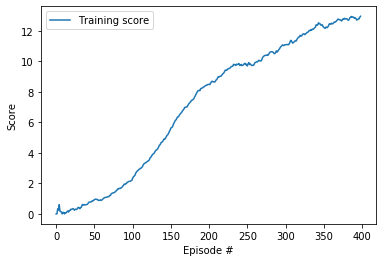

In [49]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(scores)), scores, label='Training score')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()

In [51]:
fig.savefig('nav_result.png')